In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
import matplotlib.pyplot as plt
from PIL import Image
import os
import pathlib
import random
import glob


In [ ]:
# Create data directory in your google MyDrive folder.
# Copy all three folders in your data directory to MyDrive->data folder in your google drive
# Then Execute below code
def get_data_dir_path():
  path = '/content/drive/MyDrive/data/'
  data_dir_path= pathlib.Path(path)
  data_dir_file = str(pathlib.Path(path)) + "/*.*"
  return data_dir_path

In [ ]:
# Create filter path to retive all the png files
def filter_path():
  data_dir_path_benign = str(pathlib.Path(os.path.join(get_data_dir_path(),'benign'))) + "/*.png"
  data_dir_path_normal = str(pathlib.Path(os.path.join(get_data_dir_path(),'normal'))) + "/*.png"
  data_dir_path_malignant = str(pathlib.Path(os.path.join(get_data_dir_path(),'malignant'))) + "/*.png"
  return data_dir_path_benign,data_dir_path_normal,data_dir_path_malignant

In [ ]:
# Use the filter to retrieve the corresponsing image counts
def image_count():
  data_dir_path_benign,data_dir_path_normal,data_dir_path_malignant = filter_path()
  img_count_benign = glob.glob(data_dir_path_benign,recursive=True)
  img_count_normal = glob.glob(data_dir_path_normal,recursive=True)
  img_count_malignant = glob.glob(data_dir_path_malignant,recursive=True)
  img_total_count = len(img_count_benign) + len(img_count_normal) + len(img_count_malignant)
  print("Total  Images: ", img_total_count)
  print("Benign (non-dangerous) Images: {}({})".format(len(img_count_benign), round(len(img_count_benign)*100/img_total_count, 2)))
  print("Malignant (dangerous) Images: {}({})".format(len(img_count_normal), round(len(img_count_normal)*100/img_total_count, 2)))
  print("Normal (No Traces) Images: {}({})".format(len(img_count_malignant), round(len(img_count_malignant)*100/img_total_count, 2)))
  #return img_total_count,len(img_count_benign),len(img_count_normal),len(img_count_malignant)


In [ ]:
#Display the image totals and respective class image counts
image_count()

Total  Images:  1587
Benign (non-dangerous) Images: 900(56.71)
Malignant (dangerous) Images: 266(16.76)
Normal (No Traces) Images: 421(26.53)


In [ ]:
# Configure batch size,img size and create train, validation split use function call configure_for_performance to fine tune performance
def create_data_sets():
  batch_size = 40
  img_height = 224
  img_width = 224
  train_ds = tf.keras.utils.image_dataset_from_directory(get_data_dir_path(),validation_split=0.3,subset="training",seed=123,image_size=(img_height, img_width),batch_size=batch_size)
  val_ds = tf.keras.utils.image_dataset_from_directory(get_data_dir_path(),validation_split=0.3,subset="validation",seed=123,image_size=(img_height,img_width),batch_size=batch_size)
  val_ds.class_names
  return train_ds,val_ds

In [ ]:
train_ds,val_ds = create_data_sets()

Found 1587 files belonging to 3 classes.
Using 1111 files for training.
Found 1587 files belonging to 3 classes.
Using 476 files for validation.


In [ ]:
def create_model(img_height=224,img_width=224):
  model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3,activation="softmax")
  ])
  return model


In [ ]:
model = create_model()
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,703,331 (6.50 MB)

 Trainable params: 1,703,331 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def train_model(batch_size = 32,epochs=4):
  train_ds,val_ds = create_data_sets()
  model.compile(optimizer="Adam",
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=["accuracy"])

  history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    batch_size=batch_size)
  return history

In [ ]:
#Train the model
history=train_model(batch_size = 32,epochs=4)
history.history.keys()

Found 1587 files belonging to 3 classes.
Using 1111 files for training.
Found 1587 files belonging to 3 classes.
Using 476 files for validation.
Epoch 1/4


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


28/28 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.4895 - loss: 0.9795 - val_accuracy: 0.5714 - val_loss: 0.8508
Epoch 2/4
28/28 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.6105 - loss: 0.7821 - val_accuracy: 0.6534 - val_loss: 0.7756
Epoch 3/4
28/28 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.7500 - loss: 0.5849 - val_accuracy: 0.6870 - val_loss: 0.7234
Epoch 4/4
28/28 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.7586 - loss: 0.5129 - val_accuracy: 0.6744 - val_loss: 0.7591


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

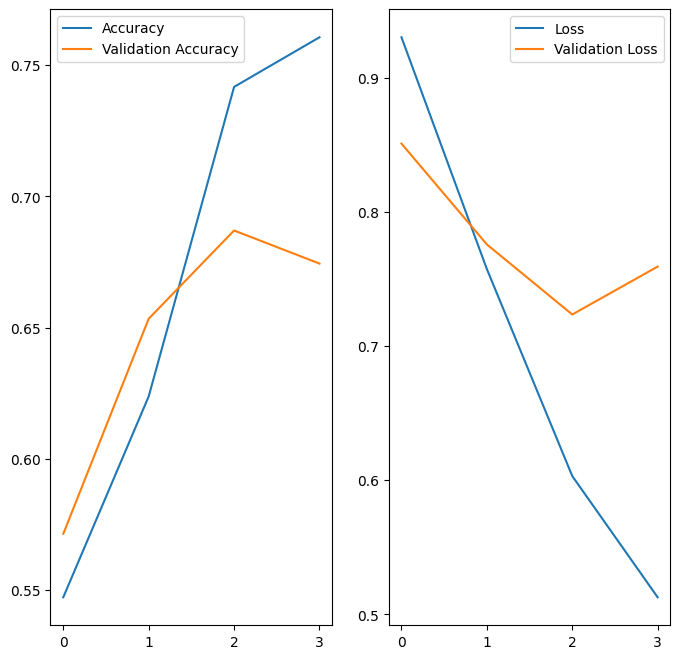

In [ ]:
#Plot the graph acc/val accuracy versus loss/validation loss
epochs=4
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
ep_range = range(epochs)
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(ep_range,acc,label='Accuracy')
plt.plot(ep_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(ep_range,loss,label='Loss')
plt.plot(ep_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()


In [ ]:
#Evaluate model with validation data set
train_ds,val_ds = create_data_sets()
loss, acc = model.evaluate(val_ds)
print('model, accuracy: {:5.2f}%'.format(100 * acc))

Found 1587 files belonging to 3 classes.
Using 1111 files for training.
Found 1587 files belonging to 3 classes.
Using 476 files for validation.
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 847ms/step - accuracy: 0.6652 - loss: 0.7885
model, accuracy: 67.44%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


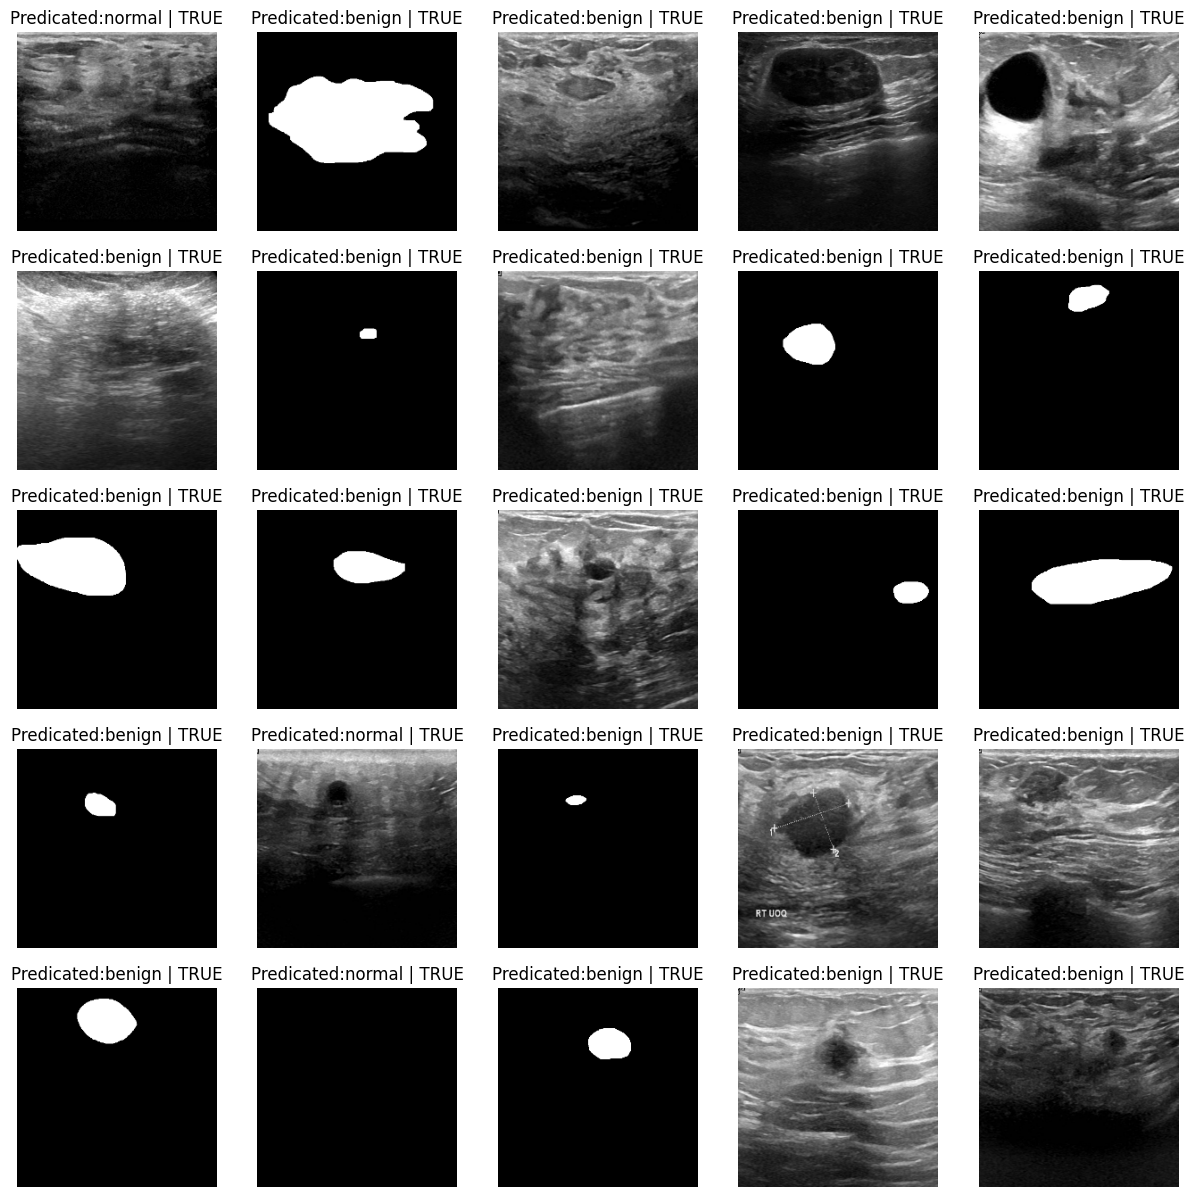

In [ ]:
#Pedict the model using Validation data
plt.figure(figsize=(15, 15))
class_names = val_ds.class_names
result = ' | False'
for images, labels in val_ds.take(1):
    for i in range(25):

        ax = plt.subplot(5, 5, i + 1)
        img = images[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        predication=""
        predictions = model.predict(img)
        predicted_class = np.argmax(predictions)
        if class_names[predicted_class] == class_names[labels[i]]:
            result = ' | TRUE'

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicated:'+ class_names[predicted_class]+result)
        plt.axis("off")


In [ ]:
#Create a folder saved_model under /content/drive/MyDrive to store bc_model.h5
def save_model():
  path = '/content/drive/MyDrive/saved_model'
  data_dir_path= pathlib.Path(path)
  data_dir_file_path = str(pathlib.Path(path)) + str("/bc_model.h5")
  model.save(data_dir_file_path)
  return data_dir_file_path

In [ ]:
#Save the model
data_dir_file_path = save_model()

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model(data_dir_file_path)
new_model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_7 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 224, 224, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 112, 112, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 112, 112, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │       1,605,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,703,333 (6.50 MB)

 Trainable params: 1,703,331 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
train_ds,val_ds = create_data_sets()
loss, acc = new_model.evaluate(val_ds)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

Found 1587 files belonging to 3 classes.
Using 1111 files for training.
Found 1587 files belonging to 3 classes.
Using 476 files for validation.


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.6652 - loss: 0.7885
Restored model, accuracy: 67.44%
